<a href="https://colab.research.google.com/github/ykato27/Image-Classification/blob/main/alexnet_cifar10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Training of AlexNet with Cifar-10 by Pytorch

adapted from :　http://cedro3.com/ai/pytorch-alexnet/


In [1]:
from matplotlib import pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.nn.init as init
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms

In [2]:
# load CIFA-10 data
train_dataset = torchvision.datasets.CIFAR10(
    root="./data/", train=True, transform=transforms.ToTensor(), download=True
)

test_dataset = torchvision.datasets.CIFAR10(
    root="./data/", train=False, transform=transforms.ToTensor(), download=True
)

print("train_dataset = ", len(train_dataset))
print("test_dataset = ", len(test_dataset))
image, label = train_dataset[0]
print(image.size())


Extracting ./data/cifar-10-python.tar.gz to ./data/
Files already downloaded and verified
train_dataset =  50000
test_dataset =  10000
torch.Size([3, 32, 32])


In [3]:
# set data loader
train_loader = torch.utils.data.DataLoader(
    dataset=train_dataset, batch_size=64, shuffle=True, num_workers=2
)

test_loader = torch.utils.data.DataLoader(
    dataset=test_dataset, batch_size=64, shuffle=False, num_workers=2
)

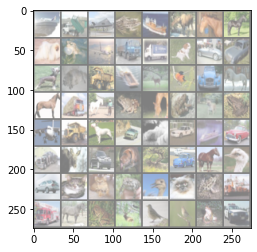

In [4]:
import matplotlib.pyplot as plt
import numpy as np


classes = (
    "plane",
    "car",
    "bird",
    "cat",
    "deer",
    "dog",
    "frog",
    "horse",
    "ship",
    "truck",
)


# functions to show an image


def imshow(img):
    img = img / 2 + 0.5  # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


dataiter = iter(train_loader)
images, labels = dataiter.next()

# print images
imshow(torchvision.utils.make_grid(images))

In [5]:
# Alexnet
class AlexNet(nn.Module):
    def __init__(self, num_classes):
        super(AlexNet, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(64, 192, kernel_size=5, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(192, 384, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(384, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        self.classifier = nn.Sequential(
            nn.Dropout(),
            nn.Linear(256 * 4 * 4, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Linear(4096, num_classes),
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), 256 * 4 * 4)
        x = self.classifier(x)
        return x


# select device
num_classes = 10
device = "cuda" if torch.cuda.is_available() else "cpu"
net = AlexNet(num_classes).to(device)

# optimizing
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(
    net.parameters(), lr=0.01, momentum=0.9, weight_decay=5e-4
)

In [6]:
# training
num_epochs = 20
train_loss_list, train_acc_list, val_loss_list, val_acc_list = [], [], [], []

### training
for epoch in range(num_epochs):
    train_loss, train_acc, val_loss, val_acc = 0, 0, 0, 0

    # ====== train_mode ======
    net.train()
    for i, (images, labels) in enumerate(train_loader):
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = net(images)
        loss = criterion(outputs, labels)
        train_loss += loss.item()
        train_acc += (outputs.max(1)[1] == labels).sum().item()
        loss.backward()
        optimizer.step()

    avg_train_loss = train_loss / len(train_loader.dataset)
    avg_train_acc = train_acc / len(train_loader.dataset)

    # ====== val_mode ======
    net.eval()
    with torch.no_grad():
        for images, labels in test_loader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = net(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            val_acc += (outputs.max(1)[1] == labels).sum().item()
    avg_val_loss = val_loss / len(test_loader.dataset)
    avg_val_acc = val_acc / len(test_loader.dataset)

    print(
        "Epoch [{}/{}], Loss: {loss:.4f}, val_loss: {val_loss:.4f}, val_acc: {val_acc:.4f}".format(
            epoch + 1,
            num_epochs,
            i + 1,
            loss=avg_train_loss,
            val_loss=avg_val_loss,
            val_acc=avg_val_acc,
        )
    )
    train_loss_list.append(avg_train_loss)
    train_acc_list.append(avg_train_acc)
    val_loss_list.append(avg_val_loss)
    val_acc_list.append(avg_val_acc)

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


Epoch [1/20], Loss: 0.0344, val_loss: 0.0306, val_acc: 0.2740
Epoch [2/20], Loss: 0.0272, val_loss: 0.0235, val_acc: 0.4352
Epoch [3/20], Loss: 0.0226, val_loss: 0.0199, val_acc: 0.5300
Epoch [4/20], Loss: 0.0192, val_loss: 0.0175, val_acc: 0.6051
Epoch [5/20], Loss: 0.0165, val_loss: 0.0155, val_acc: 0.6497
Epoch [6/20], Loss: 0.0144, val_loss: 0.0139, val_acc: 0.6878
Epoch [7/20], Loss: 0.0128, val_loss: 0.0129, val_acc: 0.7160
Epoch [8/20], Loss: 0.0113, val_loss: 0.0129, val_acc: 0.7168
Epoch [9/20], Loss: 0.0101, val_loss: 0.0117, val_acc: 0.7445
Epoch [10/20], Loss: 0.0091, val_loss: 0.0112, val_acc: 0.7537
Epoch [11/20], Loss: 0.0081, val_loss: 0.0105, val_acc: 0.7779
Epoch [12/20], Loss: 0.0073, val_loss: 0.0109, val_acc: 0.7748
Epoch [13/20], Loss: 0.0066, val_loss: 0.0104, val_acc: 0.7767
Epoch [14/20], Loss: 0.0058, val_loss: 0.0104, val_acc: 0.7863
Epoch [15/20], Loss: 0.0050, val_loss: 0.0115, val_acc: 0.7715
Epoch [16/20], Loss: 0.0045, val_loss: 0.0110, val_acc: 0.7822
E

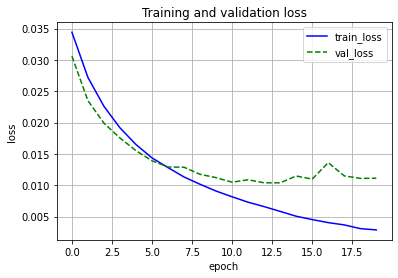

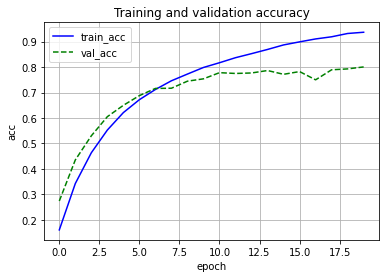

In [7]:
# plot graph
plt.figure()
plt.plot(
    range(num_epochs),
    train_loss_list,
    color="blue",
    linestyle="-",
    label="train_loss",
)
plt.plot(
    range(num_epochs),
    val_loss_list,
    color="green",
    linestyle="--",
    label="val_loss",
)
plt.legend()
plt.xlabel("epoch")
plt.ylabel("loss")
plt.title("Training and validation loss")
plt.grid()

plt.figure()
plt.plot(
    range(num_epochs),
    train_acc_list,
    color="blue",
    linestyle="-",
    label="train_acc",
)
plt.plot(
    range(num_epochs),
    val_acc_list,
    color="green",
    linestyle="--",
    label="val_acc",
)
plt.legend()
plt.xlabel("epoch")
plt.ylabel("acc")
plt.title("Training and validation accuracy")
plt.grid()

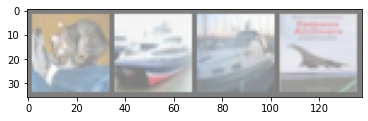

GroundTruth:    cat  ship  ship plane


In [8]:
PATH = "./cifar_net.pth"
torch.save(net.state_dict(), PATH)

dataiter = iter(test_loader)
images, labels = dataiter.next()

# print images
imshow(torchvision.utils.make_grid(images[:4]))
print("GroundTruth: ", " ".join("%5s" % classes[labels[j]] for j in range(4)))

In [9]:
net = AlexNet(num_classes)

net.load_state_dict(torch.load(PATH))
outputs = net(images)

_, predicted = torch.max(outputs, 1)

print("Predicted: ", " ".join("%5s" % classes[predicted[j]] for j in range(4)))

Predicted:    cat  ship  ship plane


以上
